In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x.shape[1])
    if steps==1: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps-1):
        #print(str(n+1)+'/'+str(steps-1),end='\r')
        print('Iteration: '+str(n+1))
        print()
        if direction=='fwd': x_,rho_,u_,tmplJ=forward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
        print('=========')
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    print('fwd pass')
    print('Initial rho: '+str(rho_[0,0]))
    print('Initial cdf: '+str(Fm(rho_[0,0])))
    #print('pseudorandom: '+str(pseudo_random(x_,u_)[0,0]))
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    print('Final cdf: '+str(Fm(rho_[0,0])))
    print('Final rho: '+str(rho_[0,0]))
    print()
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=x,rho,u
    lJ=-lm(rho_)
    print('bwd pass')
    print('Final rho: '+str(rho_[0,0]))
    print('Final cdf: '+str(Fm(rho_[0,0])))
    #print('pseudorandom: '+str(pseudo_random(x_,u_)[0,0]))
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    print('Initial cdf: '+str(Fm(rho_[0,0])))
    print('Initial rho: '+str(rho_[0,0]))
    print()
    lJ=lJ+lm(rho_)
    u_=(u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    print('Hamiltonian dynamics')
    print('Initial x: '+str(x[0,0]))
    print('Initial rho: '+str(rho[0,0]))
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    print('Final x: '+str(x_[0,0]))
    print('Final rho: '+str(rho_[0,0]))
    print()
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho))#(1-np.exp(-np.abs(rho))) #(M,d)->(M,d)
def lap_Qm(p)  : return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,z): return 0.5*np.sin(2*x+u)+0.5

In [3]:
# target specification
def lp(x): return gauss_lp(x,0,1)
def grad_lp(x): return -x

# ref specification
mu0=100
sigma0=0.3
def lq0(x): return gauss_lp(x,mu0,sigma0)
def randq0(size): return mu0+sigma0*np.random.randn(1,size)

ss=1000
q0_sample=randq0(ss)

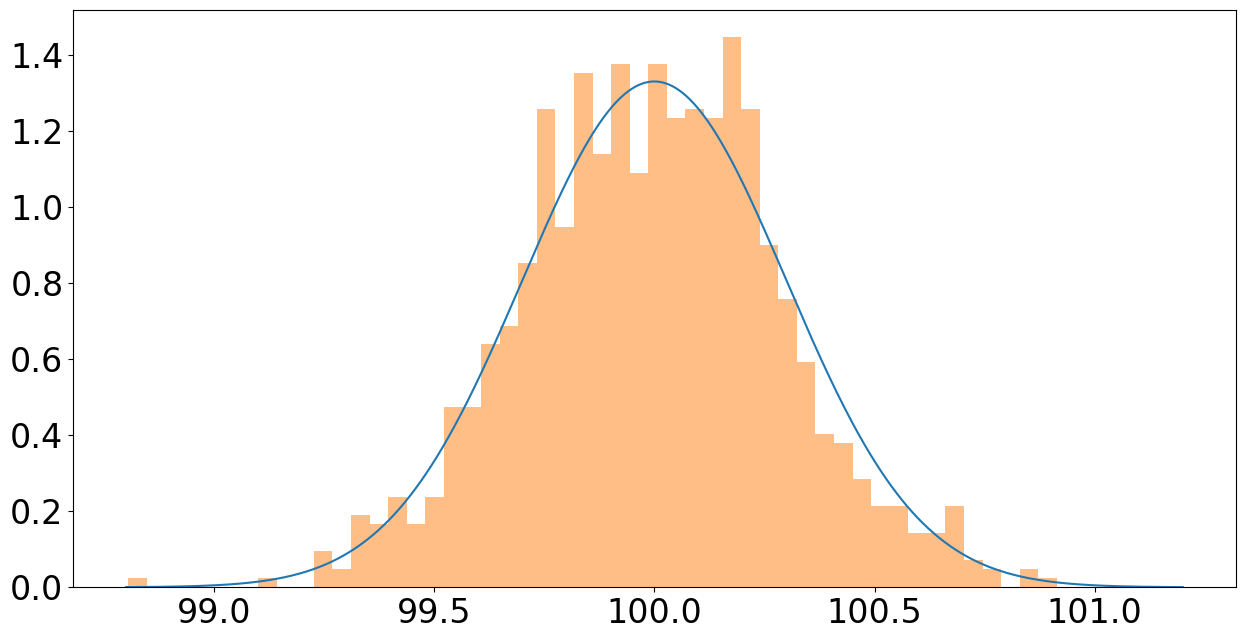

In [4]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(lq0(ttx[np.newaxis,:])))
plt.hist(q0_sample[0,:],alpha=0.5,density=True,bins=50);

## Forward pass

In [5]:
# settings
steps=100
x=q0_sample
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16
direction='fwd'

In [6]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction)

Iteration: 1

Hamiltonian dynamics
Initial x: 99.99073986338568
Initial rho: -1.719185902228879
Final x: 94.99073986338597
Final rho: -489.17288521915816

fwd pass
Initial rho: -489.17288521915816
Initial cdf: 0.0
Final cdf: 0.8659035942497642
Final rho: 1.3160491112511354

Iteration: 2

Hamiltonian dynamics
Initial x: 94.99073986338597
Initial rho: 1.3160491112511354
Final x: 89.99073986338625
Final rho: -461.13765020567934

fwd pass
Initial rho: -461.13765020567934
Initial cdf: 0.0
Final cdf: 0.00760232731271665
Final rho: -4.186153672649867

Iteration: 3

Hamiltonian dynamics
Initial x: 89.99073986338625
Initial rho: -4.186153672649867
Final x: 84.99073986338654
Final rho: -441.6398529895817

fwd pass
Initial rho: -441.6398529895817
Initial cdf: 0.0
Final cdf: 0.9604101420213512
Final rho: 2.5360351246142296

Iteration: 4

Hamiltonian dynamics
Initial x: 84.99073986338654
Initial rho: 2.5360351246142296
Final x: 79.99073986338682
Final rho: -409.9176641923191

fwd pass
Initial rho: 

In [7]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

Iteration: 1

bwd pass
Final rho: -1.7721832809764548
Final cdf: 0.0849807548602185
Initial cdf: 0.04800758566808838
Initial rho: -2.3432490652486355

Hamiltonian dynamics
Initial x: -1.009260136612917
Initial rho: -2.3432490652486355
Final x: 0.7907398633870829
Final rho: 2.5504502516867813

Iteration: 2

bwd pass
Final rho: 2.5504502516867813
Final cdf: 0.9609767412436219
Initial cdf: 0.12925534026509466
Initial rho: -1.352818268555704

Hamiltonian dynamics
Initial x: 0.7907398633870829
Initial rho: -1.352818268555704
Final x: -1.2092601366129172
Final rho: -0.6491189516202902

Iteration: 3

bwd pass
Final rho: -0.6491189516202902
Final cdf: 0.2612529635121609
Initial cdf: 0.26121057275902443
Initial rho: -0.6492812242011943

Hamiltonian dynamics
Initial x: -1.2092601366129172
Initial rho: -0.6492812242011943
Final x: -0.40926013661291705
Final rho: 1.3944180927342193

Iteration: 4

bwd pass
Final rho: 1.3944180927342193
Final cdf: 0.8760113529099723
Initial cdf: 0.36792073357597765


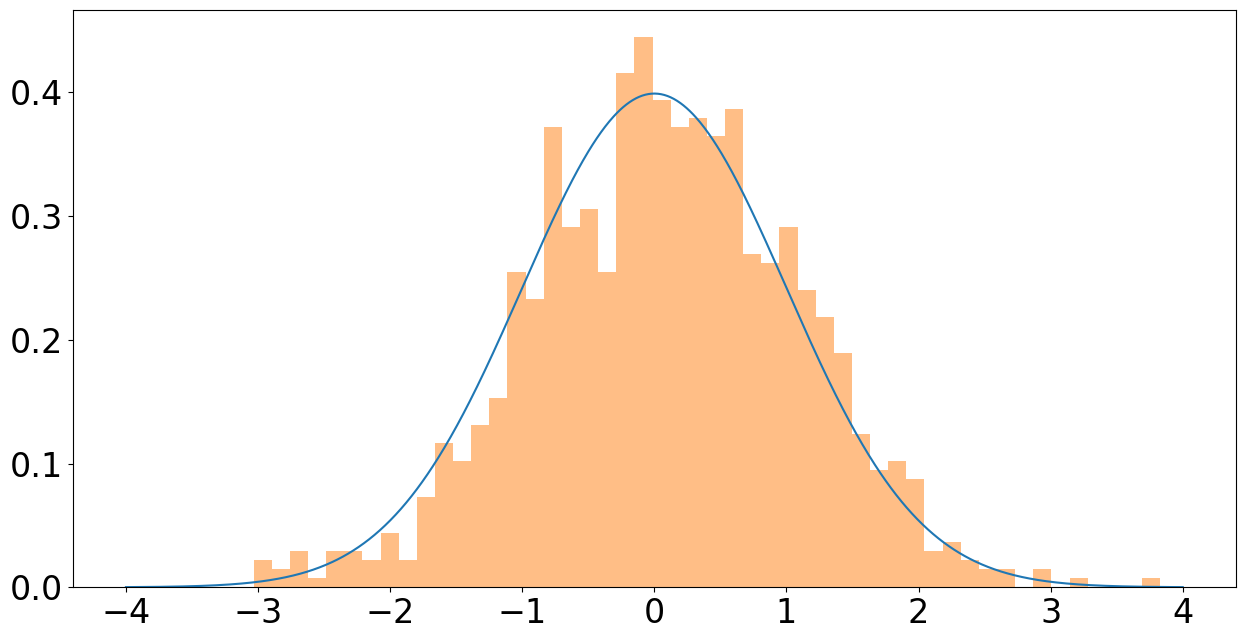

In [8]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])))
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50);

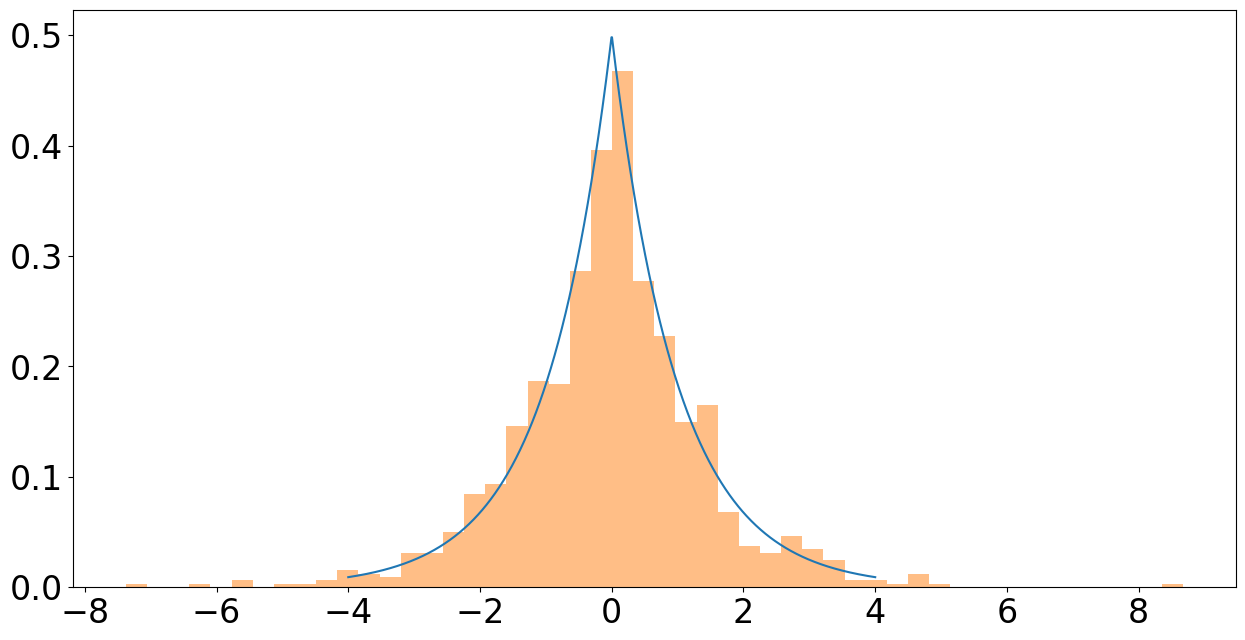

In [9]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50);

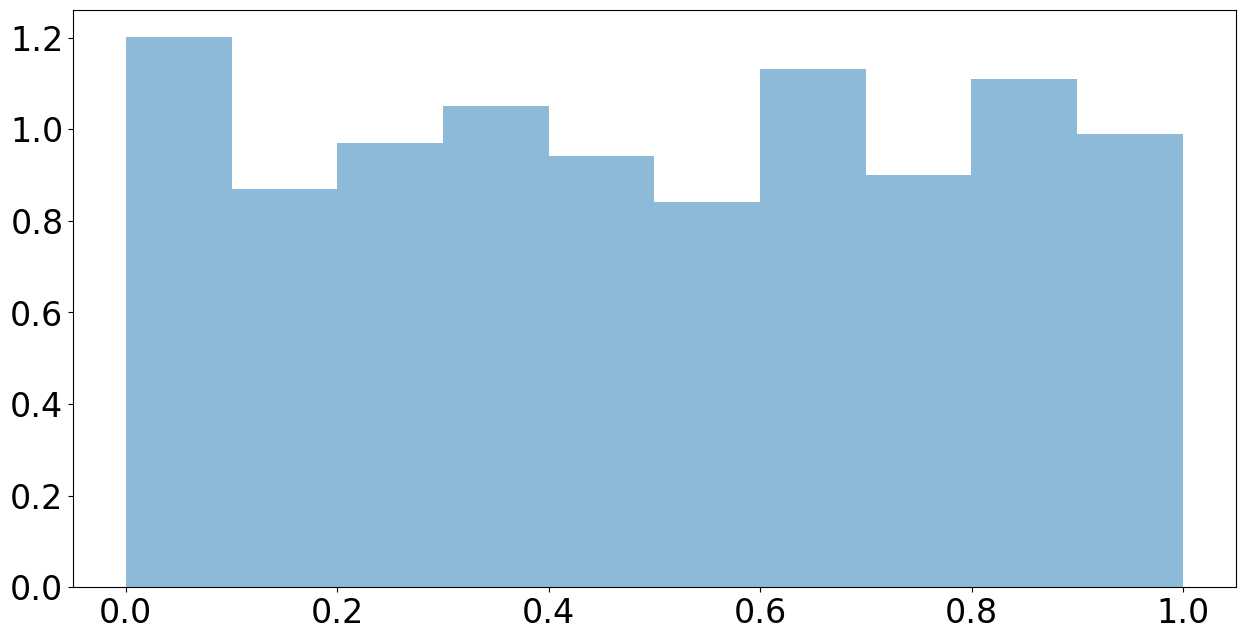

In [10]:
plt.hist(up,alpha=0.5,density=True,bins=10);

## Backward pass

In [11]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

Iteration: 1

bwd pass
Final rho: -1.7721832809764548
Final cdf: 0.0849807548602185
Initial cdf: 0.04800758566808838
Initial rho: -2.3432490652486355

Hamiltonian dynamics
Initial x: -1.009260136612917
Initial rho: -2.3432490652486355
Final x: 0.7907398633870829
Final rho: 2.5504502516867813

Iteration: 2

bwd pass
Final rho: 2.5504502516867813
Final cdf: 0.9609767412436219
Initial cdf: 0.12925534026509466
Initial rho: -1.352818268555704

Hamiltonian dynamics
Initial x: 0.7907398633870829
Initial rho: -1.352818268555704
Final x: -1.2092601366129172
Final rho: -0.6491189516202902

Iteration: 3

bwd pass
Final rho: -0.6491189516202902
Final cdf: 0.2612529635121609
Initial cdf: 0.26121057275902443
Initial rho: -0.6492812242011943

Hamiltonian dynamics
Initial x: -1.2092601366129172
Initial rho: -0.6492812242011943
Final x: -0.40926013661291705
Final rho: 1.3944180927342193

Iteration: 4

bwd pass
Final rho: 1.3944180927342193
Final cdf: 0.8760113529099723
Initial cdf: 0.36792073357597765


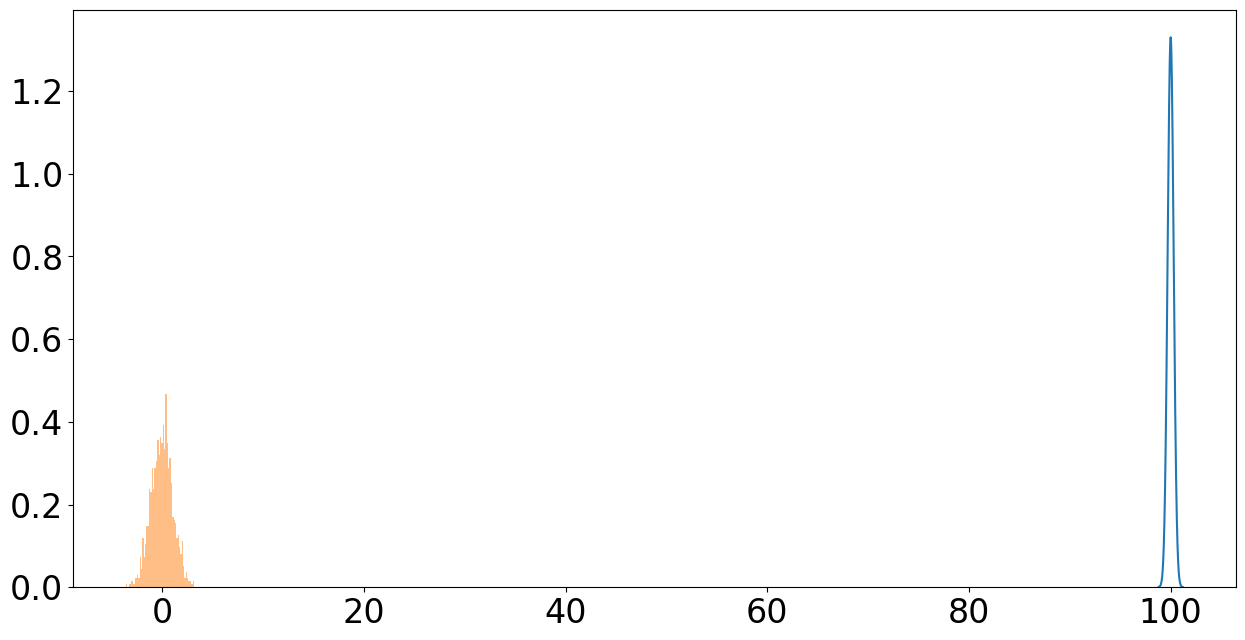

In [12]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(lq0(ttx[np.newaxis,:])))
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50);

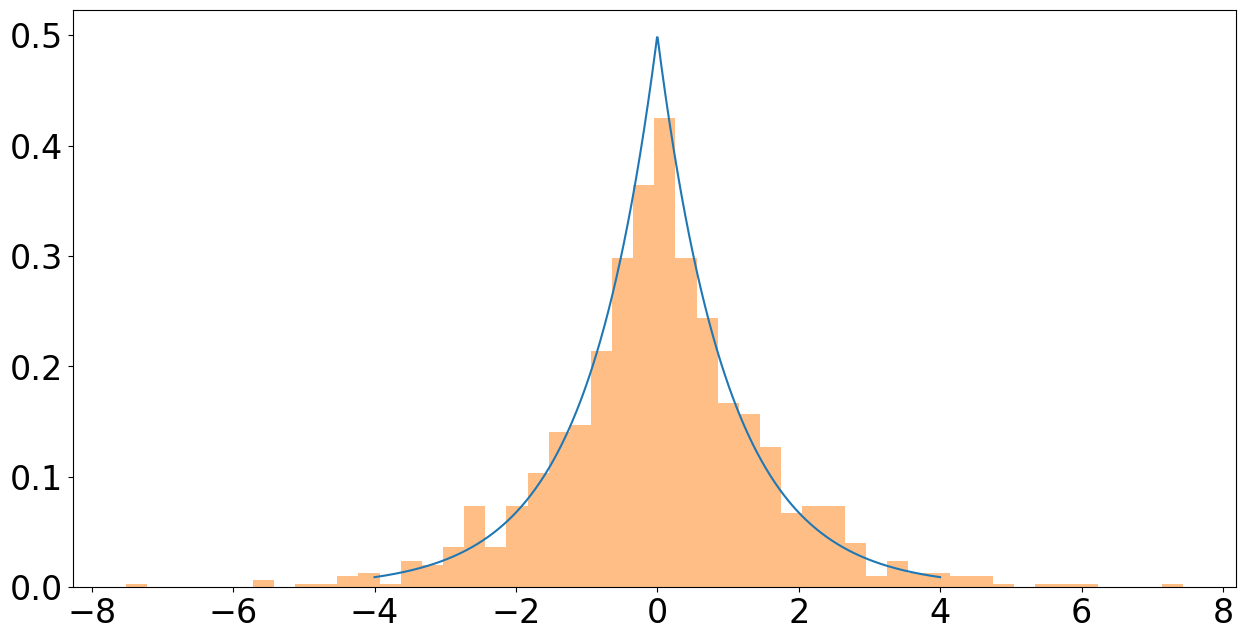

In [13]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50);

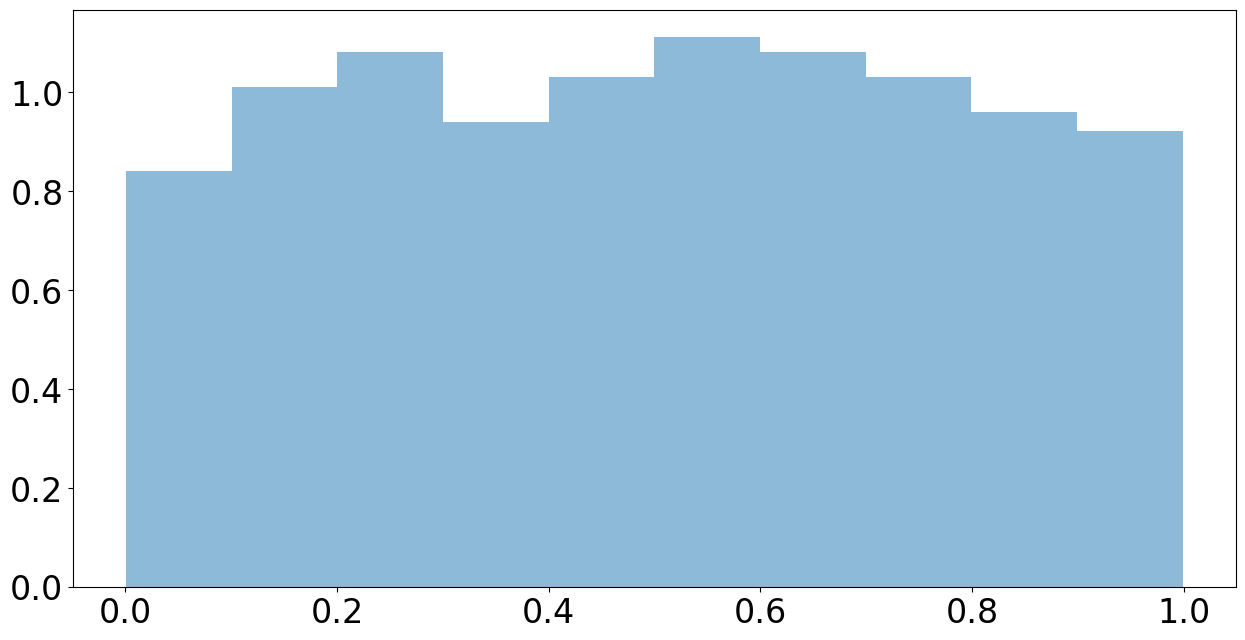

In [14]:
plt.hist(upp,alpha=0.5,density=True,bins=10);

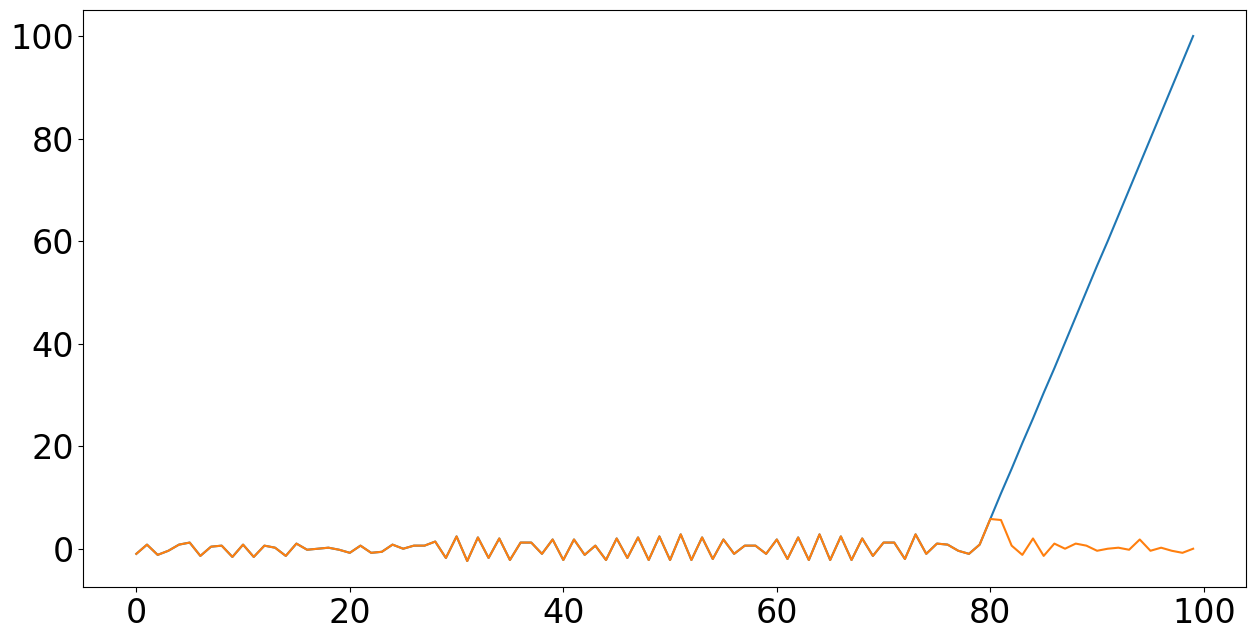

In [15]:
plt.plot(np.arange(0,steps),np.flip(xs[:,0,0]))
plt.plot(np.arange(0,steps),xps[:,0,0])

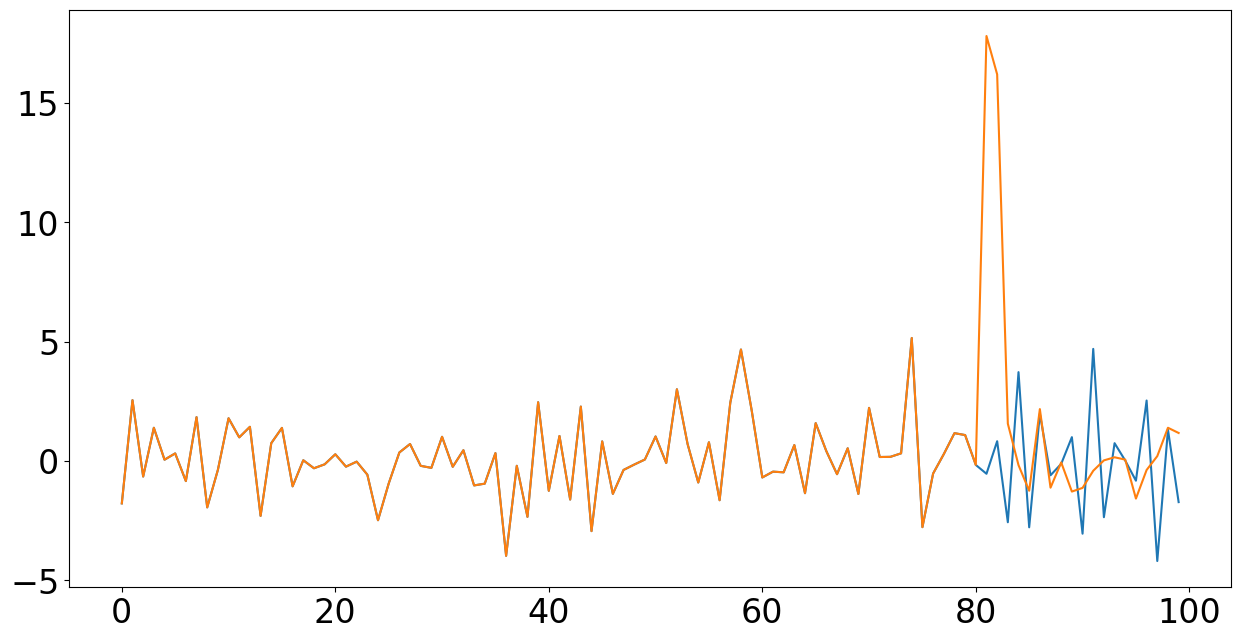

In [16]:
plt.plot(np.arange(0,steps),np.flip(rhos[:,0,0]))
plt.plot(np.arange(0,steps),rhops[:,0,0])

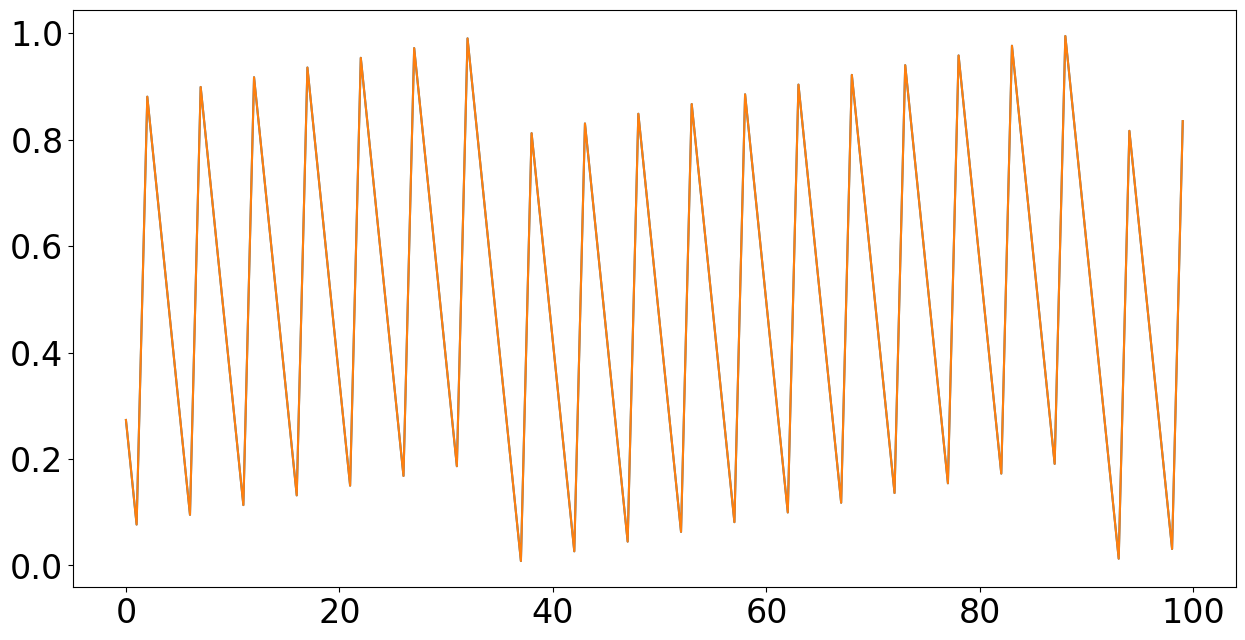

In [17]:
plt.plot(np.arange(0,steps),np.flip(us[:,0]))
plt.plot(np.arange(0,steps),ups[:,0])

In [18]:
np.flip(xs[:,0,0])

array([-1.00926014e+00,  7.90739863e-01, -1.20926014e+00, -4.09260137e-01,
        7.90739863e-01,  1.19073986e+00, -1.40926014e+00,  3.90739863e-01,
        5.90739863e-01, -1.60926014e+00,  7.90739863e-01, -1.60926014e+00,
        5.90739863e-01,  1.90739863e-01, -1.40926014e+00,  9.90739863e-01,
       -2.09260137e-01, -9.26013661e-03,  1.90739863e-01, -2.09260137e-01,
       -8.09260137e-01,  5.90739863e-01, -8.09260137e-01, -6.09260137e-01,
        7.90739863e-01, -9.26013661e-03,  5.90739863e-01,  5.90739863e-01,
        1.39073986e+00, -1.80926014e+00,  2.39073986e+00, -2.40926014e+00,
        2.19073986e+00, -1.80926014e+00,  1.99073986e+00, -2.20926014e+00,
        1.19073986e+00,  1.19073986e+00, -1.00926014e+00,  1.79073986e+00,
       -2.20926014e+00,  1.79073986e+00, -1.20926014e+00,  5.90739863e-01,
       -2.20926014e+00,  1.99073986e+00, -1.80926014e+00,  2.19073986e+00,
       -2.20926014e+00,  2.39073986e+00, -2.20926014e+00,  2.79073986e+00,
       -2.20926014e+00,  

In [19]:
xps[:,0,0]

array([-1.00926014,  0.79073986, -1.20926014, -0.40926014,  0.79073986,
        1.19073986, -1.40926014,  0.39073986,  0.59073986, -1.60926014,
        0.79073986, -1.60926014,  0.59073986,  0.19073986, -1.40926014,
        0.99073986, -0.20926014, -0.00926014,  0.19073986, -0.20926014,
       -0.80926014,  0.59073986, -0.80926014, -0.60926014,  0.79073986,
       -0.00926014,  0.59073986,  0.59073986,  1.39073986, -1.80926014,
        2.39073986, -2.40926014,  2.19073986, -1.80926014,  1.99073986,
       -2.20926014,  1.19073986,  1.19073986, -1.00926014,  1.79073986,
       -2.20926014,  1.79073986, -1.20926014,  0.59073986, -2.20926014,
        1.99073986, -1.80926014,  2.19073986, -2.20926014,  2.39073986,
       -2.20926014,  2.79073986, -2.20926014,  2.19073986, -2.00926014,
        1.79073986, -1.00926014,  0.59073986,  0.59073986, -1.00926014,
        1.79073986, -2.00926014,  2.19073986, -2.20926014,  2.79073986,
       -2.20926014,  2.39073986, -2.20926014,  1.99073986, -1.40

In [20]:
np.flip(rhos[:,0,0])

array([-1.77218328,  2.55045025, -0.64911895,  1.39441809,  0.05695874,
        0.32115497, -0.83838449,  1.83906755, -1.94073424, -0.36862077,
        1.79346536,  0.99276903,  1.43460472, -2.29484916,  0.74967054,
        1.38958968, -1.05765904,  0.03500665, -0.30121151, -0.13677181,
        0.28461932, -0.23371938, -0.02380203, -0.56834091, -2.47730371,
       -0.94254841,  0.35984594,  0.7141443 , -0.19994881, -0.2845764 ,
        1.01603598, -0.23976999,  0.45523216, -1.01994474, -0.94564493,
        0.33410258, -3.9678876 , -0.1982098 , -2.33518879,  2.46471436,
       -1.24511702,  1.05282453, -1.61108251,  2.28219212, -2.93369766,
        0.82409259, -1.37440259, -0.37202489, -0.14706229,  0.06513936,
        1.03053004, -0.08234701,  3.00650842,  0.71472991, -0.89783397,
        0.7882051 , -1.63956632,  2.44441737,  4.6735174 ,  2.13573276,
       -0.68658394, -0.44338849, -0.47089718,  0.67095124, -1.34603696,
        1.59028081,  0.41451544, -0.54923528,  0.53555886, -1.37

In [21]:
rhops[:,0,0]

array([-1.77218328,  2.55045025, -0.64911895,  1.39441809,  0.05695874,
        0.32115497, -0.83838449,  1.83906755, -1.94073424, -0.36862077,
        1.79346536,  0.99276903,  1.43460472, -2.29484916,  0.74967054,
        1.38958968, -1.05765904,  0.03500665, -0.30121151, -0.13677181,
        0.28461932, -0.23371938, -0.02380203, -0.56834091, -2.47730371,
       -0.94254841,  0.35984594,  0.7141443 , -0.19994881, -0.2845764 ,
        1.01603598, -0.23976999,  0.45523216, -1.01994474, -0.94564493,
        0.33410258, -3.9678876 , -0.1982098 , -2.33518879,  2.46471436,
       -1.24511702,  1.05282453, -1.61108251,  2.28219212, -2.93369766,
        0.82409259, -1.37440259, -0.37202489, -0.14706229,  0.06513936,
        1.03053004, -0.08234701,  3.00650842,  0.71472991, -0.89783397,
        0.7882051 , -1.63956632,  2.44441737,  4.6735174 ,  2.13573276,
       -0.68658394, -0.44338849, -0.47089718,  0.67095124, -1.34603696,
        1.59028081,  0.41451544, -0.54923528,  0.53555886, -1.37